Δημιουργία ενός _real system_ για προσομοίωση του πραγματικού συστήματος. Στο _real system_ έβαλα έξτρα όρο ODE για παραγωγή Acetate (οξέως), το οποίο επηρεάζει το pH. Στη συνέχεια, υπάρχει όρος συσχετιζόμενος με το pH που επηρέαζει την τιμή του growth rate. Τέλος, στους τελικούς υπολογισμούς των X και S από το _real system_ προσθέτω noise.

Maximum biomass concentration: 22.31 g/l at time 4.50 hours


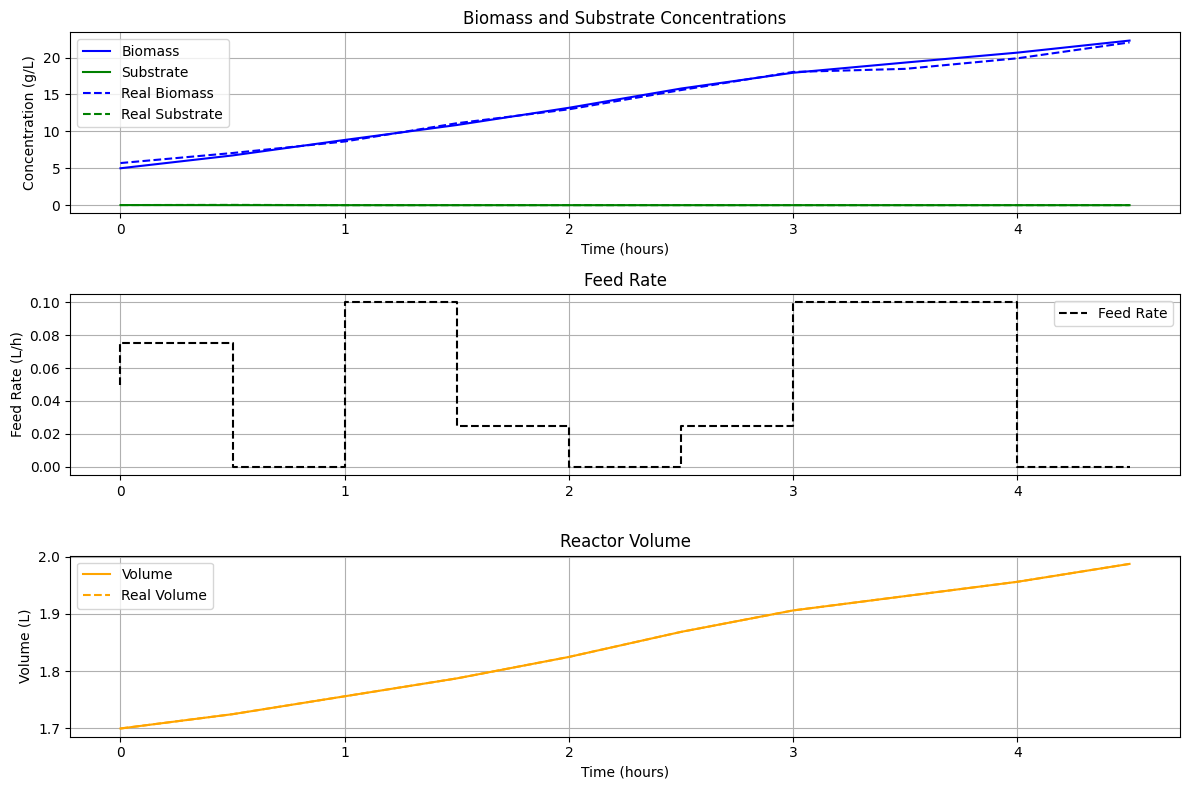

In [79]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
from scipy.integrate import solve_ivp
from scipy.optimize import minimize
from tqdm import tqdm

np.random.seed(42)

# Number of data points
NUM_SAMPLES = 1000

# Kinetic parameters
MU_MAX = 0.86980       # 1/h
K_S    = 0.000123762       # g/l
Y_XS   = 0.4357       # g/g
Y_PX   = 0.2         # g/g
Y_AX   = 0.2
S_F    = 1.43 * 200  # g/l

pH_opt = 3.8  # Optimal pH for growth

# Initial conditions
X_0 = 5
S_0 = 0.013
V_0 = 1.7
A_0 = 0.1

# ODE solver parameters
ODE_SOLVER = 'RK45'

# Time parameters
T_START = 0
T_END = 5
TIME_RANGE = int(T_END - T_START) # Absolute time 
dt = 0.5

def Fs(t):
    return np.random.choice([0, 0.1, 0.05, 0.025, 0.075])

############## Simulate system using ODEs / kinetic parameters / IC #############
def plant_model(t, y, F_func: callable):
    X, S, V = y
    F = F_func(t)
    mu = MU_MAX * S / (K_S + S)  # Monod equation
    dX_dt = mu * X - (F / V) * X
    dS_dt = -(1 / Y_XS) * mu * X + (F / V) * (S_F - S)
    dV_dt = F
    return [dX_dt, dS_dt, dV_dt]

def calculate_pH(A):
    A = A / 60.05
    Ka = 1.75e-5
    a = 1
    b = Ka
    c = -Ka * A
    H_plus = (-b + np.sqrt(b**2 - 4*a*c)) / (2*a)
    return - np.log10(H_plus) if H_plus > 0 else 14
    
def real_system(t, y, F_func: callable,):
    X, S, V, A = y
    F = F_func(t)
    
    pH = calculate_pH(A)
    mu = MU_MAX * S / (K_S + S) * np.exp(- 1.1 * (pH - pH_opt)**2)
    dX_dt = mu * X - (F / V) * X
    dS_dt = -(1 / Y_XS) * mu * X + (F / V) * (S_F - S)
    dV_dt = F
    dA_dt = Y_AX * mu * X - (F / V) * A
    return [dX_dt, dS_dt, dV_dt, dA_dt]

def simulate(F: callable, plot: bool=True, real: bool=True) -> np.ndarray:
    """ Simulate bioreactor system using ODEs 
    - F: feed rate (assumed constant)
    - real: if True, simulate also the real system model; otherwise, only plant model
    """
    t_points = np.arange(T_START, T_END, dt)
    F_func = interp1d(t_points, [F(t) for t in t_points], kind="linear", fill_value="extrapolate")
    
    sol = solve_ivp(plant_model, t_span=(T_START, T_END), y0=[X_0, S_0, V_0], args=(F_func,), t_eval=np.arange(T_START, T_END, dt), method='LSODA', rtol=1e-6, atol=1e-12)

    if real:
        sol_real = solve_ivp(real_system, t_span=(T_START, T_END), y0=[X_0, S_0, V_0, A_0], args=(F_func,), t_eval=np.arange(T_START, T_END, dt), method='LSODA', rtol=1e-6, atol=1e-12)
        # Add noise to the real system
        sol_real.y[0] += np.random.normal(0, sol_real.y[0].max() * 0.02, size=sol_real.y[0].shape)
        sol_real.y[1] += np.random.normal(0, sol_real.y[1].max() * 0.02, size=sol_real.y[1].shape)
    
    print(f'Maximum biomass concentration: {np.max(sol.y[0]):.2f} g/l at time {sol.t[np.argmax(sol.y[0])]:.2f} hours')
    if plot:
        plt.figure(figsize=(12, 8))
        
        # Plot Biomass and Substrate
        ax1 = plt.subplot(3, 1, 1)
        ax1.plot(sol.t, sol.y[0], label='Biomass', color='blue')
        ax1.plot(sol.t, sol.y[1], label='Substrate', color='green')
        if real:
            ax1.plot(sol_real.t, sol_real.y[0], label='Real Biomass', color='blue', linestyle='--')
            ax1.plot(sol_real.t, sol_real.y[1], label='Real Substrate', color='green', linestyle='--')
        ax1.set_title('Biomass and Substrate Concentrations')
        ax1.set_xlabel('Time (hours)')
        ax1.set_ylabel('Concentration (g/L)')
        ax1.legend(loc='upper left')
        ax1.grid()

        # Plot Feed Rate
        ax2 = plt.subplot(3, 1, 2)
        ax2.step(sol.t, [F(t) for t in sol.t], label='Feed Rate', color='black', linestyle='--')
        ax2.set_ylabel('Feed Rate (L/h)')
        ax2.set_title('Feed Rate')
        ax2.legend(loc='upper right')
        ax2.grid()

        # Plot Volume
        ax3 = plt.subplot(3, 1, 3)
        ax3.plot(sol.t, sol.y[2], label='Volume', color='orange')
        if real:
            ax3.plot(sol_real.t, sol_real.y[2], label='Real Volume', color='orange', linestyle='--')
        ax3.set_title('Reactor Volume')
        ax3.set_xlabel('Time (hours)')
        ax3.set_ylabel('Volume (L)')
        ax3.legend()
        ax3.grid()

        plt.tight_layout()
        plt.show()
        
    return sol

sol = simulate(Fs)